(tutorial_measuringfairness)=

# Measuring Group Fairness

In this tutorial we will explore how we can measure notions of group fairness via a disaggregated analysis in Python using Fairlearn. As a running example, we consider pre-trial risk assessment scores produced by the COMPAS recidivism risk assessment tool.

---
**Learning Objectives**. After this tutorial you are able to:
* perform a disaggregated analysis in Python using Fairlearn;
* describe the relevance of reliability of estimates and validity of measurements in relation to quantitative fairness assessments;
* explain the incompatibility between three group fairness criteria;
---

## COMPAS: A Pre-Trial Risk Assessment Tool
COMPAS is a decision support tool used by courts in the United States to assess the likelihood of a defendant becoming a recidivist; i.e., relapses into criminal behavior. In particular, COMPAS risk scores are used in **pre-trial risk assessment**.

```{admonition} What is pre-trial risk assessment in the US judicial system?
After somebody has been arrested, it will take some time before they go to trial. The primary goal of pre-trial risk assessment is to determine the likelihood that the defendant will re-appear in court at their trial. Based on the assessment, a judge decides whether a defendent will be detained or released while awaiting trial. In case of release, the judge also decides whether bail is set and for which amount. Bail usually takes the form of either a cash payment or a bond. If the defendant can't afford to pay the bail amount in cash - which can be as high as \$50,000 - they can contract a bondsmen. For a fee, typically around 10\% of the bail, the bondsmen will post the defendant's bail.

If the defendant can afford neither bail nor a bail bond, they have to prepare for their trial while in jail. [This](https://eu.clarionledger.com/story/opinion/columnists/2020/05/28/cant-afford-bail-woman-describes-experience-mississippi-bail-fund-collective/5257295002/) [is](https://medium.com/dose/bail-is-so-expensive-it-forces-innocent-people-to-plead-guilty-72a3097a2ebe) [difficult](https://facctconference.org/2018/livestream_vh210.html). The time between getting arrested and a bail hearing can take days, weeks, months, or even years. In some cases, the decision is between pleading guilty and going home. Consequently, people who cannot afford bail are much more likely to plead guilty to a crime they did not commit. Clearly, a (false) positive decision of the judge will have a big impact on the defendant's prospects. 

On the other extreme, false negatives could mean that dangerous individuals are released into society and do not show up for their trial.
```

Proponents of risk assessment tools argue that they can lead to more efficient, less biased, and more consistent decisions compared to human decision makers. However, concerns have been raised that the scores can replicate historical inequalities.

### Propublica's Analysis of COMPAS
In May 2016, investigative journalists of Propublica released a critical analysis of COMPAS. **Propublica's assessment: COMPAS wrongly labeled black defendants as future criminals at almost twice the rate as white defendants**, while white defendants were mislabeled as low risk more often than black defendants ([Propublica, 2016](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing)). 

The analysis of COMPAS is likely one of the most well-known examples of algorithmic bias assessments. Within the machine learning research community, the incident sparked a renewed interest in fairness of machine learning models.

In [5]:
# data wrangling
import pandas as pd
import numpy as np

# visualization
import matplotlib

# other
import sklearn
import fairlearn

# this tutorial has been tested with the following versions
print("pandas        Tested version: 2.0.3   Your version: %s" % pd.__version__)
print("numpy         Tested version: 1.24.4  Your version: %s" % np.__version__)
print("matplotlib    Tested version: 3.8.3   Your version: %s" % matplotlib.__version__)
print("scikit-learn  Tested version: 1.2.1   Your version: %s" % sklearn.__version__)
print("fairlearn     Tested version: 0.10.0  Your version: %s" % fairlearn.__version__)

pandas        Tested version: 2.0.3   Your version: 2.0.3
numpy         Tested version: 1.24.4  Your version: 1.21.5
matplotlib    Tested version: 3.8.3   Your version: 3.5.3
scikit-learn  Tested version: 1.2.1   Your version: 1.3.2
fairlearn     Tested version: 0.10.0  Your version: 0.10.0


In [6]:
# import functionality
import matplotlib.pyplot as plt
from fairlearn.metrics import MetricFrame, make_derived_metric
from sklearn.metrics import precision_score
from fairlearn.metrics import selection_rate, count, false_positive_rate, false_negative_rate
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference
from sklearn.calibration import CalibrationDisplay

## Load Dataset
For this tutorial we will use the [data](https://github.com/propublica/compas-analysis/blob/master/compas-scores-two-years.csv) that was collected by ProPublica through public records requests in Broward County, Florida. We will pre-process the data similar to Propublica's analysis.

In [7]:
# load data
data = pd.read_csv('compas-scores-two-years.csv')
# filter similar to propublica
data = data[(data['days_b_screening_arrest'] <= 30) &
                (data['days_b_screening_arrest'] >= -30) &
                (data['is_recid'] != -1) &
                (data['c_charge_degree'] != "O") &
                (data['score_text'] != "N/A")]
# select columns
data = data[['sex', 'age', 'race', 'priors_count', 'decile_score', 'two_year_recid']]
# cut-off score 5 
data['decile_score_cutoff']= data['decile_score'] >= 5
# inspect
data.head()

,sex,age,race,priors_count,decile_score,two_year_recid,decile_score_cutoff
0,Male,69,Other,0,1,0,False
1,Male,34,African-American,0,3,1,False
2,Male,24,African-American,4,4,1,False
5,Male,44,Other,0,1,0,False
6,Male,41,Caucasian,14,6,1,True


The data now contains the following features:

* *sex*. The defendant's sex, measured as US census sex categories (either *Male* or *Female*).
* *race*. The defendant's race, measured as US census race categories.
* *age*. The defendant's age on the COMPAS screening date. 
* *decile_score*. The COMPAS score expressed in deciles of the raw risk score. The deciles are obtained by ranking scale scores of a normative group and dividing these scores into ten equal-sized groups. Normative groups are gender-specific. For example, females are scored against a female normative group. According to Northpointe's documentation, a decile score of 1-4 is low, 5-7 medium, and 8-10 high.
* *priors_count*. The number of prior charges up to but not including the current offense.
* *two_year_recid*. Recidivism, defined as any offense that occurred within two years of the COMPAS screening date.
* *decile_score_cutoff*. The binarized COMPAS score based on a cut-off score of 5.

--- 

## Demographic Parity
In a classification scenario, the **selection rate** is the proportion of positive predictions. If selection rates differ across groups, there is a risk of **allocation harm**: some groups are allocated more (or less) resources than others. For example, in a hiring scenario, the selection rate of male applicants may be higher than that of female or non-binary applicants.

The risk of allocation harm is particularly prevalent in cases where disparities exist in the observed data, which are replicated by the machine learning model.

```{admonition} Demographic parity
Demographic Parity holds if, for all values of y and a, 

$$P(\hat{Y} = y | A = a) = P(\hat{Y} = y | A = a')$$

where $\hat{Y}$ is the output of our model and $A$ the set of sensitive characteristics.
```

In other words, demographic parity requires the output of the model to be independent of the sensitive characteristic. We can quantify the extent to which demographic parity is violated through a fairness metric, such as the maximum _demographic parity difference_ (i.e., the maximum difference in selection rates beteen groups).

### What normative or empirical assumptions underly demographic parity as a fairness constraint?
When we consider a violation of demographic parity to be undesirable, this points to two possible assumptions:
1. We assume that *everybody **is** equal*. For example, we may assume that qualifications for a particular job are independent of somebody's gender - even if the data suggests otherwise. In particular, we may believe that social biases in historical hiring decisions have skewed base rates in the data set, resulting in measurement bias.
2. We assume that *everybody **should be** equal*. For instance, we may assume that the job qualification are distributed unequally across genders in current society, but this is due to factors outside of the individual's control, such as lacking opportunities due to social gender norms.

When predictive models are used to allocate resources, disparities in selection rates can be an important measure of potential fairness-related harm. However, treating demographic parity as an optimization objective can have unintended and sometimes undesirable side effects. Enforcing demographic parity might lead to differences in treatment across sensitive groups, causing otherwise similar people to be treated differently. For example, if base rates differ between racial groups, a perfectly accurate model cannot satisfy demographic parity. As a result, we must misclassify some instances for selection rates to be equal. However, demographic parity does not put any constraints on _which_ samples are to be classified differently: as long as you pick the same proportion for each group, demographic parity holds. For example, to fulfill demographic parity, we could simply randomly select additional instances from the group with the lower selection rate -- irrespective of their personal characteristics and scores.

--- 

### Measuring Demographic Parity using Fairlearn

We can use Fairlearn's `MetricFrame` class to investigate the selection rate across groups. 

The class has the following basic parameters: 
* `metrics`: a callable metric (e.g., `selection_rate`, or `false_positive_rate`) or a dictionary of callables.
* `y_true` : the ground-truth labels.
* `y_pred` : the predicted labels.
* `sensitive_features`: the sensitive features. Note that there can be multiple sensitive features.
* `control_features`: the control features. Control features are features for which you'd like to investigate disparaties separately (i.e., "control for"). For example, you expect the feature can "explain" some of the observed disparities between sensitive groups.

At initialization, the `MetricFrame` object computes the input metric(s) for each group defined by sensitive features.
* `MetricFrame.bygroup`: a pandas dataframe with the metric value for each group.
* `MetricFrame.overall`: a float (or dataframe, if `control_features` are used) with the metric value as computed over the entire dataset.

We can also summarize the results of the `MetricFrame` using one of the following methods:
* `MetricFrame.difference()` : return the maximum absolute difference between groups for each metric.
* `MetricFrame.ratio()` : return the minimum ratio between groups for each metric.
* `MetricFrame.group_max()` : return the maximum value of the metric over the sensitive features.
* `MetricFrame.group_min()` : return the minimum value of the metric over the sensitive features.

The `MetricFrame` object is useful to do a thorough investigation of disparities. When we have (already) identified a definition of fairness that is relevant in our scenario, we may want to optimize for it during model selection. For this, it can be useful to have a single value that summarizes the disparity in a fairness metric.

We can directly summarize the extent to which demographic parity is violated using `demographic_parity_difference()` metric. This metric can also be used in, for example, a grid search. All fairness metrics in Fairlearn have the following arguments:
* `y_true`
* `y_pred`
* `sensitive_features`
* `method`: the method that is used to summarize the difference or ratio across groups. 
    * `'between_groups'`: aggregate the difference as the max difference between any two groups
    * `'to_overall'`: aggregate the difference as the max difference between any group and the metric value as computed over the entire dataset.
    
There are several predefined metrics, such as `fairlearn.metrics.demographic_parity_difference()` and `fairlearn.metrics.equalized_odds_ratio()`. It is also possible to define your own fairness metric, based on a metric function (e.g., a scikit-learn performance metric such as `sklearn.metrics.precision_score`) using `fairlearn.metrics.make_derived_metric()`.

---

In the pre-trial risk assessment scenario, unequal selection rates mean that we predict, on average, recidivism more often for one group than the other. Let's investigate the selection rate of COMPAS.

In [9]:
# compute metrics by group
mf = MetricFrame(metrics={'selection rate (COMPAS)' : selection_rate}, 
                 y_true=data['two_year_recid'], 
                 y_pred=data['decile_score_cutoff'], 
                 sensitive_features=data['race'])
# print results
print(mf.by_group)
print("Overall SR: %.2f" % mf.overall[0])

# summarize demographic parity as the max difference between groups
print("demographic parity diff: %.2f" % mf.difference(method='between_groups')[0])

# summarize demographic parity using the metric (this gives the exact same result as mf.difference())
dpd = demographic_parity_difference(y_true=data['two_year_recid'], 
                                    y_pred=data['decile_score_cutoff'], 
                                    sensitive_features=data['race'], 
                                    method='between_groups') # summarize as the max difference between any of the groups
print("demographic parity diff: %.2f" % dpd)

                  selection rate (COMPAS)
race                                     
African-American                 0.576063
Asian                            0.225806
Caucasian                        0.330956
Hispanic                         0.277014
Native American                  0.727273
Other                            0.204082
Overall SR: 0.45
demographic parity diff: 0.52
demographic parity diff: 0.52


These results suggest that COMPAS' selection rate is substantially higher for _Native American_ and _African-American_ compared to other racial categories. The largest difference in selection rates is between _Native American_ and _Other_. However, before we jump to conclusions, we need to consider the reliability of these estimates.

## The Problem of Small Sample Sizes

Group fairness metrics heavily rely on the estimation of group statistics such as the selection rate or the false positive rate. In many cases, the number of individuals in the data that belong to a particular subgroup can be very small. With small sample sizes, statistical estimates can become very uncertain. In those cases, it is impossible to even accurately *assess* the risk of fairness-related harm - let alone mitigate it. The problem of small sample sizes is further exacerbated when we consider intersectional subgroups, such as Black women. This is particularly problematic, as harms often accumulate at the intersection of marginalized groups. 

Lets consider the sample sizes for racial categories in the COMPAS data set.

In [6]:
# number of instances in each racial category
display(data['race'].value_counts())

# we can also include count as a metric in MetricFrame
mf = MetricFrame(metrics={'count' : count}, 
                 y_true=data['two_year_recid'], 
                 y_pred=data['decile_score_cutoff'], 
                 sensitive_features=data['race'])
display(mf.by_group)

race
African-American    3175
Caucasian           2103
Hispanic             509
Other                343
Asian                 31
Native American       11
Name: count, dtype: int64

,count
race,
African-American,3175
Asian,31
Caucasian,2103
Hispanic,509
Native American,11
Other,343


Clearly, the large majority of instances are _African-American_ or _Caucasian_, while only 11 and 31 instances are classified as _Native American_ and _Asian_ respectively.

To get a better idea of how small sample sizes affect the uncertainty of our estimates, we can use **bootstrapping** to derive confidence intervals.

```{admonition} Bootstrap Confidence Intervals

Bootstrap resampling is a non-parametric approach to derive a confidence interval (CI) for an estimate of a statistic, such as the mean of a variable in a particular population. In the context of fairness assessments, confidence intervals give us an indication of the precision of our estimates: if we were to repeat our fairness assessment 100 times, gathering 100 samples (i.e., datasets) of the population (e.g., defendants in Florida) and compute a 95% CI for the metric under investigation (e.g., selection rate), 95 of the confidence intervals would capture the metric value (i.e., the true selection rate) in the population.

Bootstrap confidence intervals are computed based on resampling. First, we create a number of bootstrap samples. Each bootstrap sample involves (a) creating a new dataset of equal size to the original, via random sampling with replacement, and (b) evaluating the metric of interest on this dataset. Second, we compute the distribution of the set of bootstrap samples and estimate confidence intervals based on this distribution function. For example, we may compute the 0.05 and 0.95 quantiles of selection rates computed over the bootstrap samples to derive a 90% CI of the selection rate. 

Note that bootstrapping assumes the data sample is representative of the population. If we're interested in the selection rate of African-American defendants in Florida, but defendants in Broward County are not representative of defendants in Florida (e.g., in terms of demographic composition or the distribution of the types of crime), we cannot make any claims regarding our confidence that the CI contains the true selection rate of the population, i.e. defendants in Florida.

```

### Computing Bootstrap Confidence Intervals with `MetricFrame`

`MetricFrame` has several parameters that control the bootstrapping procedure: 

* `n_boot` : the number of bootstrap samples;
* `ci_quantiles` : the quantiles we wish to compute;
* `random_state` : a random seed, which can be used to control the randomness involved in bootstrapping for reproducibility purposes;

Bootstrapping in Fairlearn provides us with confidence intervals for the estimates in our disaggregated analysis (e.g., the selection rate for a particular sensitive group) as well as fairness metrics (e.g., the maximum difference in selection rates across groups).

Note that **the confidence intervals produced by `MetricFrame` are not a replacement for statistical tests**. That is, we cannot simply compare the CIs across groups and conclude that the proportions are equal or unequal. Instead, we must confine ourselves to considering the size of the confidence intervals and whether they are indicating that we need to gather more data.

,0.025,0.975
,selection rate (COMPAS),selection rate (COMPAS)
race,,
African-American,0.560148,0.590021
Asian,0.082296,0.363561
Caucasian,0.315466,0.350783
Hispanic,0.242634,0.314458
Native American,0.492424,1.000000
Other,0.169057,0.250043


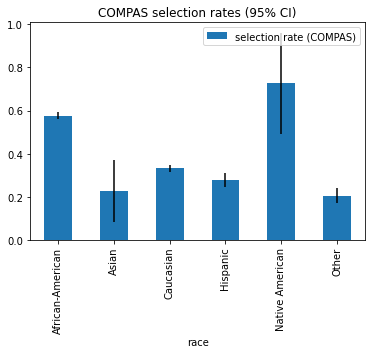

demographic parity diff: 0.52 (95 CI [0.38, 0.82])


In [7]:
# compute metrics by group
mf = MetricFrame(metrics={'selection rate (COMPAS)' : selection_rate}, 
                 y_true=data['two_year_recid'], 
                 y_pred=data['decile_score_cutoff'], 
                 sensitive_features=data['race'],
                 n_boot=100,
                 ci_quantiles=[0.025, 0.975], # for a 95% CI, we need the 0.025 and 0.975 quantiles
                 random_state=42)

# display quantiles
errors = pd.concat(mf.by_group_ci, keys=mf.ci_quantiles, axis=1)
display(errors)

# plot errorbars
# matplotlib requires errorbars to be supplied as the size of the errorbar
errors['size min'] = mf.by_group - errors.loc[:,0.025]
errors['size max'] = errors.loc[:,0.975] - mf.by_group
mf.by_group.plot(kind='bar', yerr=[errors['size min'], errors['size max']])
plt.title("COMPAS selection rates (95% CI)")
plt.show()

# print confidence interval of maximum demographic parity difference
dpd = mf.difference()
dpd_ci = mf.difference_ci()
print("demographic parity diff: %.2f (95 CI [%.2f, %.2f])" % (dpd.iloc[0], dpd_ci[0].iloc[0], dpd_ci[1].iloc[0]))

Clearly, the uncertainty of our estimates differs quite a lot across groups. As expected, estimates for _Asian_ and _Native American_ defendants are extremely unreliable. The small sample sizes also affect our confidence in the estimate of the maximum demographic parity difference: the 95% CI ranges from 0.38 to 0.82.

#### What to do about small sample sizes? 
Unfortunately, there is no simple solution. The most obvious action is, of course, to collect more data. In practice, however, this may not always be feasible. Another option is to merge some sensitive groups into an overarching group. While merging groups reduces uncertainty of the estimate, it can negatively affect the validity of the fairness assessment - especially when sensitive groups are affected differently by discriminatory patterns in society. For example, in the case of COMPAS, collapsing _Asian_ and _Native American_ into a single category is only sensible if we assume that these groups have similar characteristics, particularly in relation to the types of discrimination might face in society. A third option is to apply more sophisticated statistical techniques to derive more precise estimates, but this is outside of the scope of this tutorial.


```{admonition} Construct Validity of Sensitive Characteristics

So far, we have mostly considered the confidence in our estimates. Another important factor is the validity of our measurements. **Construct validity** is a concept from the social sciences that refers to *the extent to which a measurement actually measures the phenomenon we are trying to measure*. Many sensitive characteristics, such as race and gender, are **social constructs**, which are multidimensional and dynamic. As such, there are many different ways to operationalize the construct 'race' as a feature in your data set. For example, dimensions of race include self-reported racial identity, observed appearance-based race, observed interaction-based race, etc. This is important, because [how you measure sensitive group membership changes the conclusions you can draw](https://arxiv.org/abs/1912.03593). The racial categories in the COMPAS dataset are based on those that are used by Broward County Sheriff’s Office. This is not necessarily a valid measurement of race. For example, Hispanic is redefined as a racial category (rather than an ethnicity). Additionally, each individual is labeled with just a single category, whereas some people may identify with multiple races. It is also unclear whether the measurements are the result of self-identification or observed by police officers.

```
For the sake of simplicity, in the remainder of this tutorial we follow Propublica's analysis and focus on the two largest groups: _African-American_ and _Caucasian_.

In [8]:
# select two largest groups
data = data[(data['race'] == 'African-American') | (data['race'] == 'Caucasian')]

At this point we may wonder whether disparities are introduced by COMPAS, or whether can we see a similar pattern in the original data. The selection rate observed in the data is also referred to as **base rate**.

In [9]:
# compute selection rate by group
mf = MetricFrame(metrics={'selection rate (COMPAS)' : selection_rate}, 
                 y_true=data['two_year_recid'], 
                 y_pred=data['decile_score_cutoff'], 
                 sensitive_features=data['race'],
                 n_boot=100,
                 ci_quantiles=[0.025, 0.975], # for a 95% CI, we need the 0.025 and 0.975 quantiles
                 random_state=42)
display(mf.by_group)

# print confidence interval of maximum demographic parity difference
dpd = mf.difference()
dpd_ci = mf.difference_ci()
print("demographic parity diff: %.2f (95 CI [%.2f, %.2f])" % (dpd.iloc[0], dpd_ci[0].iloc[0], dpd_ci[1].iloc[0]))

# by choosing y_pred to be ground truth instead of predictions, we can easily compute the base rate in the data
mf = MetricFrame(metrics={'base rate' : selection_rate}, 
                 y_true=data['two_year_recid'], 
                 y_pred=data['two_year_recid'], 
                 sensitive_features=data['race'],
                 n_boot=100, 
                 ci_quantiles=[0.025, 0.975], # for a 95% CI, we need the 0.025 and 0.975 quantiles
                 random_state=42,
                )
display(mf.by_group)

# max base rate difference between groups
bpd = mf.difference()
bpd_ci = mf.difference_ci()
print("base rate diff: %.2f (95 CI [%.2f, %.2f])" % (bpd.iloc[0], bpd_ci[0].iloc[0], bpd_ci[1].iloc[0]))

,selection rate (COMPAS)
race,
African-American,0.576063
Caucasian,0.330956


demographic parity diff: 0.25 (95 CI [0.22, 0.27])


,base rate
race,
African-American,0.52315
Caucasian,0.39087


base rate diff: 0.13 (95 CI [0.11, 0.16])


Although the difference is substantially smaller compared to COMPAS' selection rates, the base rates do differ across groups. There are several possible explantions of why these disparities arise in the data:

* **The observed recidivism rates may not represent the actual recidivism rates.** Our target variable considers *re-arrests*, which is only a subset of the true cases of recidivism. It could be the case that the observed disparities reflect racist policing practices, rather than the true crime rate.
* **Social deprivations may have caused the true underlying recidivism rate to be different across groups.** In other words, African-American defendants may truely be more likely to fall back into criminal behavior, due to dire personal circumstances.

**Note that we cannot know which explanation holds from the data alone!** For this, we need a deeper understanding of the social context and data collection practices.

```{admonition} Construct Validity of Target Variables

Similar to sensitive characteristics, construct validity is important to consider when you define your target variable. In the context of fairness, [a lack of construct validity in the target variable can be a source of downstream model unfairness](https://arxiv.org/abs/1912.05511).

* [Healthcare costs can be a biased measurement of healthcare needs](https://science.sciencemag.org/content/366/6464/447.abstract), as costs may reflect patients' economic circumstances rather than their health
* Historical hiring decisions are not necessarily equivalent to historical employee quality, due to systemic and/or (unconscious) social biases in the hiring process.
* Observed fraud is only a subsample of actual fraud. If potential cases of fraud are not selected randomly, there is a risk of selection bias. If the selection biass is associated with sensitive group membership, some groups may be overscrutinized causing the observed fraud rate to be inflated.

```

## Equalized Odds

If error rates differ across groups, there is a risk of **allocation harm**: the algorithm does not provide equal opportunities to all. For example, in a hiring scenario, we may mistakingly reject strong female candidates more often than strong male candidates. Additionally, there is the risk of a **quality-of-service harm**: even if the target variable does not relate to the distribution of a particular resource, it makes more mistakes for some groups than for others. For example, a facial recognition system may fail disproportionately for some groups.

The risk of quality-of-service harm is particularly prevalent if the relationship between the features and target variable is different across groups. The risk is further amplified if less data is available for some groups.  For example, strong candidates for a data science job may have either a quantitative social science background or a computer science background. Now imagine that in the past, hiring managers have mostly hired applicants with a computer science degree, but hardly any social scientists. As a result, a machine learning model could mistakingly penalize people who do not have a computer science degree. If relatively more women have a social science background, the error rates will be higher for women compared to men, resulting in a quality-of-service harm.

```{admonition} Equalized Odds
Equalized Odds holds if, for all values of $y$ and $a$, 

$$P(\hat{Y} = y | A = a, Y = y) = P(\hat{Y} = y | A = a', Y = y)$$ 

where $\hat{Y}$ is the output of our model, $Y$ the observed outcome, and $A$ the set of sensitive characteristics.

In other words, the **false positive rate** and **false negative rate** should be equal across groups. 
```

### What normative or empirical assumptions underly equalized odds as a fairness constraint?
Equalized odds quantifies the understanding of fairness that (1) we should not make more mistakes for some groups than for other groups, and (2) different types of mistakes should be evaluated separately. Similar to demographic parity, the equalized odds criterion acknowledges that the relationship between the features and the target may differ across groups and that this should be accounted for. The constraint is less strict compared to demographic parity, as it allows the disparity to be 'explained' by the target variable $Y$. A violation of equalized odds indicates either, (1) the model is less able to distinguish positives from negatives for some groups compared to others, (2) the distribution of positives and negatives differs between groups, resulting in _different_ types of misclassifications. For example, if the proportion of qualified men is higher compared to the proportion of qualified women, the proportion of men that receive a high score will also be higher compared to the proportion of women that receive a high score. As a result, men will be misclassified as a false positive more often compared to women. Vice versa, women are more likely to be misclassified as a false negative compared to men.

--- 

As we have seen in the introduction, a false positive prediction in pre-trial risk assessment can have large consequences for the involved defendant. It may even result in the defendant pleading guilty to a crime they did not commit. Let's compute the false positive rates and false negative rates.

In [10]:
# compute metrics
mf = MetricFrame(metrics = 
                 {'false positive rate' : false_positive_rate,
                  'false negative rate' : false_negative_rate}, 
                 y_true=data['two_year_recid'], 
                 y_pred=data['decile_score_cutoff'], 
                 sensitive_features=data[['race']])
display(mf.by_group)

# summarize differences
for i in mf.difference('between_groups').items():
    print("%s diff: %.2f" % i)

# alternatively: summarize equalized odds in one metric (which is the max of fpr diff and fnr diff)
dpd = equalized_odds_difference(data['two_year_recid'], 
                                    data['decile_score_cutoff'], 
                                    sensitive_features=data['race'], 
                                    method='between_groups')
print("equalized odds diff: %.2f" % dpd)

,false positive rate,false negative rate
race,,
African-American,0.423382,0.284768
Caucasian,0.220141,0.496350


false positive rate diff: 0.20
false negative rate diff: 0.21
equalized odds diff: 0.21


Similar to Propublica's assessment, we find that **the false positive rate is almost twice as high for African Americans compared to Caucasians**. In other words, African Americans are more often falsely predicted to be re-arrested. At the same time, the false negative rate is much higher for Caucasians, indicating that Caucasians are more often released even though they will re-offend. 

## Equal Calibration

Northpointe, the developers of COMPAS, responded to Propublica's analysis that COMPAS scores are fair because the scores are **equally calibrated** across racial groups. In other words, for each possible risk score, the probability that you belong to a particular class is the same, regardless of the group to which you belong.


```{admonition} Equal Calibration
Equal Calibration holds if, for all values of $y$, $a$, and $r$ 

$$P(Y = y | A = a, \hat{Y} = y) = P(Y = y | A = a', \hat{Y} = y)$$ 

where $\hat{Y}$ is the output of our model, $Y$ the observed outcome, and $A$ the set of sensitive characteristics.
```

For example, given that an instance is predicted to belong to the negative class, the probability of actually belonging to the negative class is independent of sensitive group membership.  In the binary classification scenario, equal calibration implies that the **positive predictive value** (which is equivalent to *precision*) and **negative predictive value** are equal across groups.

As opposed to demographic parity and equalized odds, requiring equal calibration usually does not require an active intervention. That is, we usually get equal calibration "for free" when we use machine learning approaches.

### What normative or empirical assumptions underly equal calibration as a fairness constraint?
Equal calibration quantifies an understanding of fairness that a score should have the same *meaning*, regardless of sensitive group membership. Similar to equalized odds, the underlying assumption is that the target variable is a reasonable representation of what reality looks or should look like. However, as opposed to equalized odds, equal calibration does take into consideration that the relationship between features and target variable may be different across groups.

--- 

Let's verify Northpointe's claim regarding the calibration of COMPAS scores.

In [11]:
def negative_predictive_value_score(y_true, y_pred, **kwargs):
    """
    NPV is not in scikit-learn, but is the same as PPV but with 0 and 1 swapped. 
    """
    return precision_score(y_true, y_pred, pos_label=0, **kwargs)

# compute metrics
mf = MetricFrame(metrics = 
                 {'positive predictive value' : precision_score,
                  'negative predictive value' : negative_predictive_value_score}, 
                 y_true=data['two_year_recid'], 
                 y_pred=data['decile_score_cutoff'], 
                 sensitive_features=data['race'])
display(mf.by_group)

# summarize differences
for i in mf.difference('between_groups').items():
    print("%s diff: %.2f" % i)

# we can also define a custom fairness metric for npv (giving the same results as mf.differnece())
npv_score_diff = make_derived_metric(metric=negative_predictive_value_score, transform='difference')
npvd = npv_score_diff(data['two_year_recid'], 
                    data['decile_score_cutoff'], 
                    sensitive_features=data['race'], 
                    method='between_groups')
print("npv diff: %.2f" % npvd)

,positive predictive value,negative predictive value
race,,
African-American,0.649535,0.648588
Caucasian,0.594828,0.710021


positive predictive value diff: 0.05
negative predictive value diff: 0.06
npv diff: 0.06


We can further investigate the calibration of the original COMPAS scores (i.e., before we binarized them using a cut-off value of 5) in more detail by plotting a **calibration curve** for each racial group.

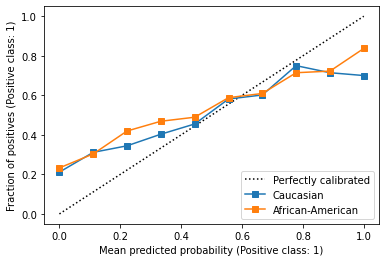

In [12]:
# normalize predicted scores to from 0 to 1
data['decile_score_norm'] = (data['decile_score'] - 1)/9

# display calibration curves
ax = plt.gca()
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for race in ['Caucasian', 'African-American']:
    CalibrationDisplay.from_predictions(y_true=data[data['race']==race]['two_year_recid'], 
                                        y_prob=data[data['race']==race]['decile_score_norm'],
                                        n_bins=10,
                                        ax=ax, 
                                        label=race)
plt.show()

Indeed, we see that the calibration curves are similar for both groups (though both quite far from perfectly calibrated!), indicating that COMPAS scores are equally calibrated for African-Americans and Caucasians.


## Impossibilities 

In this tutorial, we have seen that some understanding of fairness (equal calibration) holds for COMPAS scores, whereas others (equalized odds and demographic parity) do not. These findings are not specific to the COMPAS case. 

It has been proven mathematically that in cases where *sensitive group membership is **not** independent of the target variable* and the classifier's output is well calibrated, **it is impossible for these three fairness criteria to hold at the same time** (see e.g., [Kleinberg et al., 2016](https://arxiv.org/pdf/1609.05807.pdf)).

* *Demographic Parity and Equal Calibration*. If group membership is related to the target variable, one group has a higher base rate (i.e., proportion of positives) than the other. If we want to enforce demographic parity in this scenario, we need to select more positives in the disadvantaged group than suggested by the observed target outcome. Consequently, the positive predictive value of our classifier will be different for each group, because the proportion of true positives from all instances we predicted to be positive will be lower in the disadvantaged group.

* *Demographic parity and Equalized Odds*. As before, the only way to satisfy demographic parity with unequal base rates is to classify some instances of the disadvantaged group as positives, even if they should be negatives according to the observed target variable. Hence, provided that the scores are well-calibrated (i.e., we use the same cut-off score for each group), we cannot satisfy both demographic parity and equalized odds at the same time.

* *Equal Calibration and Equalized Odds*. When a classifier is imperfect, it is impossible to satisfy both equal calibration and equalized odds at the same time. An intuitive explanation of this impossibility is to recall that equal calibration requires equal *positive predictive value* across groups (a.k.a., precision), whereas equalized odds requires equal false negative rates, which corresponds to equal true positive rates (a.k.a. recall). If we adjust our classifier such that the precision is equal across groups, this will decrease the recall, and vice versa.

It is important to realize that **the impossibilities are not so much a mathematical dispute, but a dispute of the underlying understanding of what we consider fair**. Which notion of fairness is relevant depends on your assumptions about the context and your underlying moral values. In practice, make your assumptions explicit when discussing fairness with other stakeholders, as this allows for a more meaningful discourse.

# Concluding Remarks
The main take aways of this tutorial are:
* Different **fairness metrics** represent different **theoretical understandings** of fairness, which is reflected in their incompatibility.
* **Reliability of estimates** is an important problem in fairness assessments, as often (small) subgroups of a dataset are evaluated.
* **Construct validity** is central to assessing fairness and should be considered when you define a target variable, measure sensitive group membership, and choose a fairness metric.

# Discussion Points
* What notion of fairness is most appropriate in the pre-trial risk assessment scenario, in your opinion? Why? If you feel like you don't have enough information to answer this question, which information would you need to make an informed judgment?
* A way to account for unequal selection rates is to use a different cut-off score for each group. Note that this policy has the consequence that two defendants with the same risk score but a different race may be classified differently. Under what conditions would you consider such a policy fair, if any? Does your conclusion depend on the underlying source of the bias in the data?
* How equal is equal enough? How much overall performance would you sacrifice for optimizing for a fairness metric, if any?